<a href="https://colab.research.google.com/github/FrenchKrab/IS2023-powerset-diarization/blob/master/notebook_ps_diarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Powerset multi-class cross entropy loss for neural speaker diarization - Example notebook

This is the example notebook of the paper "*Powerset multi-class cross entropy loss for neural speaker diarization*", published at Interspeech 2023.

The corresponding official repository is available here

## Installing dependencies

Make sure you're **using a GPU** (Runtime -> Change runtime type) before starting the notebook.

Please download the ckpt file at https://github.com/FrenchKrab/IS2023-powerset-diarization/blob/master/models/powerset/powerset_pretrained.ckpt and place it in `/content/`.

**Restart the runtime once this part is complete** (Runtime -> Restart runtime) and then continue to next part, else you will encounter a pyannote.database error.

In [ ]:
# Note: pyannote.audio's version is the oldest compatible version tested with this method.
# pyannote.database version 5.1 (newer) is used for convenience and ease of use.
!pip install -qq rich
!pip install -qq git+https://github.com/pyannote/pyannote-audio.git@e3dc7d68cc60c7d4f89df005b58674aa936b0882
!pip install -qq git+https://github.com/pyannote/pyannote-database.git@bac3225ee76333b4e8332ff309ea554f062660ff

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.2/217.2 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 kB 53.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 20.6 MB/s eta 0:0

In [ ]:
# download AMI-SDM mini corpus
%cd /content/
!git clone https://github.com/pyannote/AMI-diarization-setup
%cd /content/AMI-diarization-setup/pyannote/
!bash download_ami_sdm_mini.sh
!cd /

/content
Cloning into 'AMI-diarization-setup'...
remote: Enumerating objects: 977, done.
remote: Counting objects: 100% (977/977), done.
remote: Compressing objects: 100% (429/429), done.
remote: Total 977 (delta 390), reused 949 (delta 369), pack-reused 0
Receiving objects: 100% (977/977), 1.67 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (390/390), done.
/content/AMI-diarization-setup/pyannote
ES2002a.Array1-01.w 100%[===================>]  38.84M  46.2MB/s    in 0.8s    
2023-06-07 14:49:38 URL:https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2002a/audio/ES2002a.Array1-01.wav [40727594/40727594] -> "amicorpus/ES2002a/audio/ES2002a.Array1-01.wav" [1]
ES2003a.Array1-01.w 100%[===================>]  34.78M  41.2MB/s    in 0.8s    
2023-06-07 14:49:39 URL:https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2003a/audio/ES2003a.Array1-01.wav [36472536/36472536] -> "amicorpus/ES2003a/audio/ES2003a.Array1-01.wav" [1]
ES2004a.Array1-01.w 100%[===================>]  32.0

## Loading data and adapting the segmentation model to AMI mini

In [ ]:
from pyannote.database import registry, FileFinder

registry.load_database("/content/AMI-diarization-setup/pyannote/database.yml")
protocol = registry.get_protocol("AMI-SDM.SpeakerDiarization.mini", preprocessors={"audio": FileFinder()})

'AMI-SDM.SpeakerDiarization.only_words' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI-SDM.SpeakerDiarization.mini' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.only_words' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.mini' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.
'AMI.SpeakerDiarization.word_and_vocalsounds' found in /content/AMI-diarization-setup/pyannote/database.yml does not define the 'scope' of speaker labels (file, database, or global). Setting it to 'file'.


In [ ]:
# Fix eventual locale errors with colab (happens when you want to use a command such as cd)
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from pyannote.audio import Model
from pyannote.audio.tasks import Segmentation
# The task Segmentation has been renamed to SpeakerDiarization in newer versions

PRETRAINED_PATH = "/content/powerset_pretrained.ckpt"

segmentation_model = Model.from_pretrained(PRETRAINED_PATH)
segmentation_model.task = Segmentation(protocol, duration=5.0, max_speakers_per_chunk=3, max_speakers_per_frame=2)
segmentation_model.setup("fit")

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Protocol AMI-SDM.SpeakerDiarization.mini does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


The training should take a bit less than 15 minutes on a Google Colab T4 GPU

---



In [ ]:
from types import MethodType
from torch.optim import Adam
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichProgressBar,
)
from pytorch_lightning import Trainer

# we use Adam optimizer with 1e-4 learning rate
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-4)

segmentation_model.configure_optimizers = MethodType(configure_optimizers, segmentation_model)

# we monitor diarization error rate on the validation set
# and use to keep the best checkpoint and stop early
monitor, direction = segmentation_model.task.val_monitor
checkpoint = ModelCheckpoint(
    monitor=monitor,
    mode=direction,
    save_top_k=1,
    every_n_epochs=1,
    save_last=False,
    save_weights_only=False,
    filename="{epoch}",
    verbose=False,
)
early_stopping = EarlyStopping(
    monitor=monitor,
    mode=direction,
    min_delta=0.0,
    patience=10,
    strict=True,
    verbose=False,
)

callbacks = [RichProgressBar(), checkpoint, early_stopping]

# we train for at most 20 epochs (might be shorter in case of early stopping)
from pytorch_lightning import Trainer
trainer = Trainer(accelerator="gpu",
                  callbacks=callbacks,
                  max_epochs=20,
                  gradient_clip_val=0.5)
trainer.fit(segmentation_model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   ┃ Name              ┃ Type             ┃ Params ┃       In sizes ┃                                  Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 0 │ sincnet           │ SincNet          │ 42.6 K │ [32, 1, 80000] │                              [32, 60, 293] │
│ 1 │ lstm              │ LSTM             │  1.4 M │  [32, 293, 60] │    [[32, 293, 256], [[8, 32, 128], [8, 32, │
│   │                   │                  │        │                │                                     128]]] │
│ 2 │ linear            │ ModuleList       │ 49.4 K │              ? │                                          ? │
│ 3 │ classifier        │ Linear           │    903 │ [32, 293, 128] │                               [32, 293, 7] │
│ 4 │ activation        │ LogSoftmax       │      0 │   [32, 293, 7] │                               [32, 293, 7] │
│ 5 │ powerset          │ Powerset         │      0 │              ? │                                          ? │
│ 6 │ validation_metric │ MetricCollection │      0 │              ? │                                          ? │
└───┴───────────────────┴──────────────────┴────────┴────────────────┴────────────────────────────────────────────┘

Trainable params: 1.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.5 M                                                                                                
Total estimated model params size (MB): 5

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# Using the adapted segmentation model
## Segmentation model output

Path to the best checkpoint obtained from the adaption training.

In [ ]:
checkpoint.best_model_path

'/content/lightning_logs/version_0/checkpoints/epoch=19.ckpt'

Compute and display the local segmentation models (pretrained and adapted) outputs over a sliding window.

In [ ]:
from pyannote.audio import Inference
from pyannote.audio.pipelines.utils import get_devices

STEP = 5.0

(device,) = get_devices(needs=1)
file1 = next(protocol.test())

inf_pretrained = Inference(model=PRETRAINED_PATH, step=STEP, device=device)
inf_adapted = Inference(model=checkpoint.best_model_path, step=STEP, device=device)

local_out_pretrained = inf_pretrained(file1)
local_out_adapted = inf_adapted(file1)

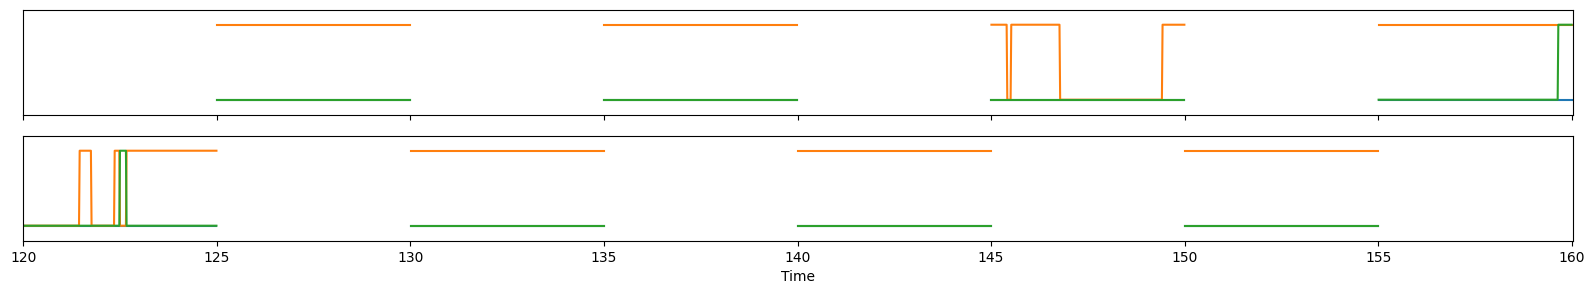

In [ ]:
from pyannote.core import notebook, Segment
notebook.crop = Segment(120,160)

local_out_pretrained

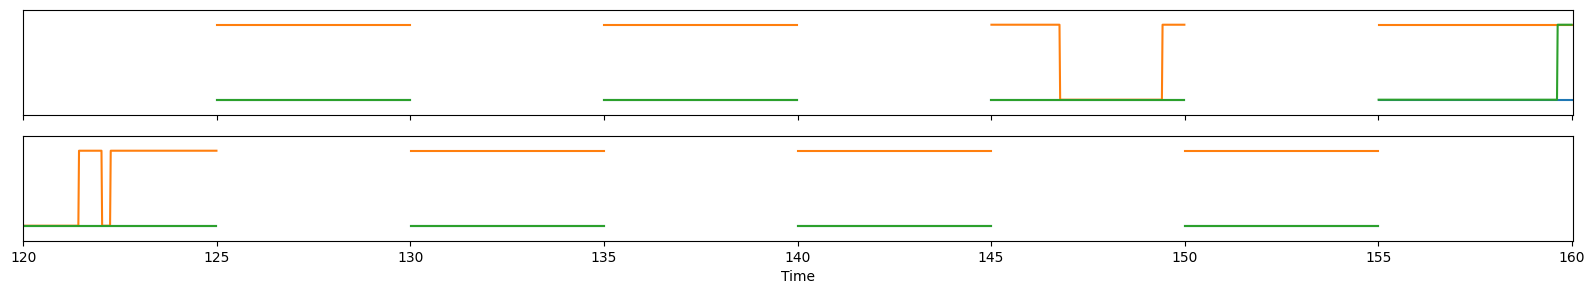

In [ ]:
local_out_adapted

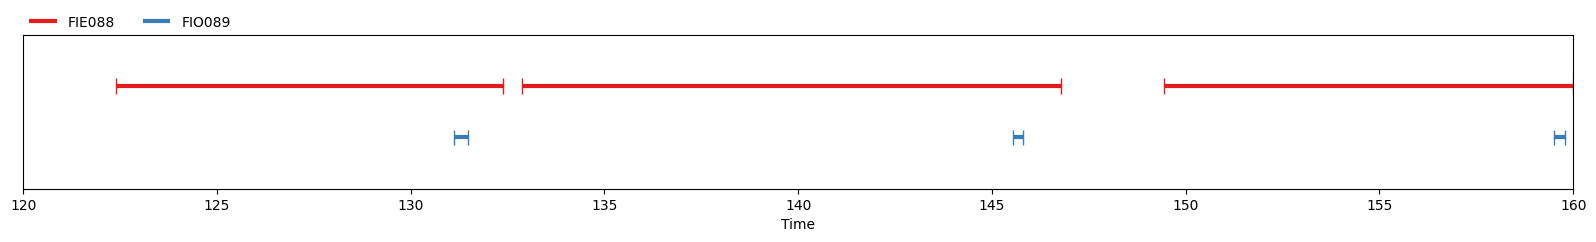

In [ ]:
file1["annotation"]

## Adapted pipeline output
Now apply the full speaker diarization pipeline using the pretrained/adapted models to compare the outputs.
We can then observe the difference between pretrained/adapted/reference.

In [ ]:
from pyannote.audio.pipelines import SpeakerDiarization as SpeakerDiarizationPipeline

STEP=5.0

# hyperparameters used for AMI
PIPELINE_PARAMS = {
    "clustering": {
        "method": "centroid",
        "min_cluster_size": 15,
        "threshold": 0.6285824248662424,
    },
    "segmentation": {
        "min_duration_off": 0.0,
    },
}

adapted_model = Model.from_pretrained(checkpoint.best_model_path)
pipeline_adapted = SpeakerDiarizationPipeline(adapted_model, embedding="speechbrain/spkrec-ecapa-voxceleb", clustering="AgglomerativeClustering").to(device)
pipeline_adapted.instantiate(PIPELINE_PARAMS)
out_adapted = pipeline_adapted(next(protocol.test()))

pipeline_pretrained = SpeakerDiarizationPipeline(PRETRAINED_PATH, embedding="speechbrain/spkrec-ecapa-voxceleb", clustering="AgglomerativeClustering").to(device)
pipeline_pretrained.instantiate(PIPELINE_PARAMS)
out_pretrained = pipeline_pretrained(next(protocol.test()))

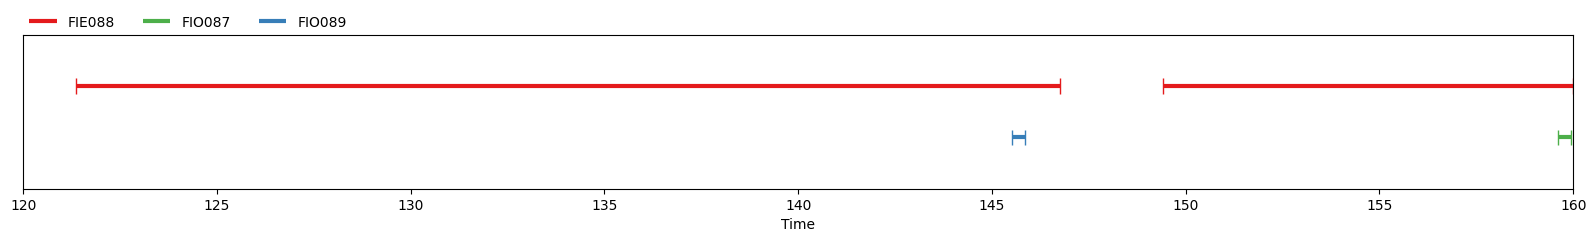

In [ ]:
notebook.crop = Segment(120,160)

out_pretrained

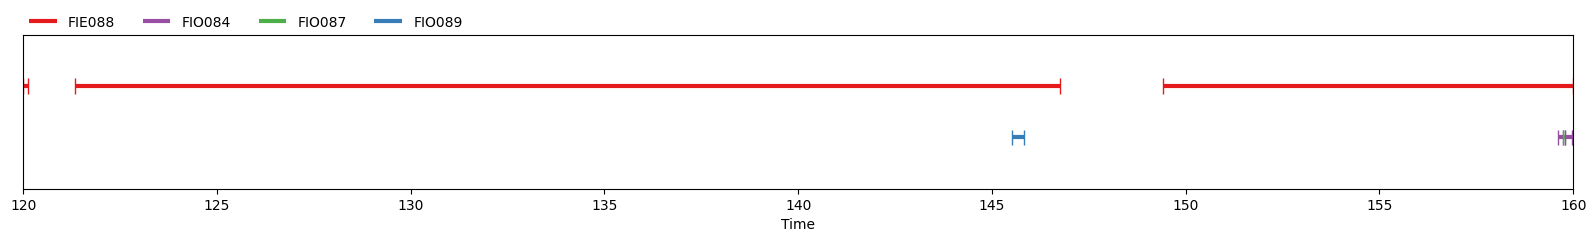

In [ ]:
out_adapted

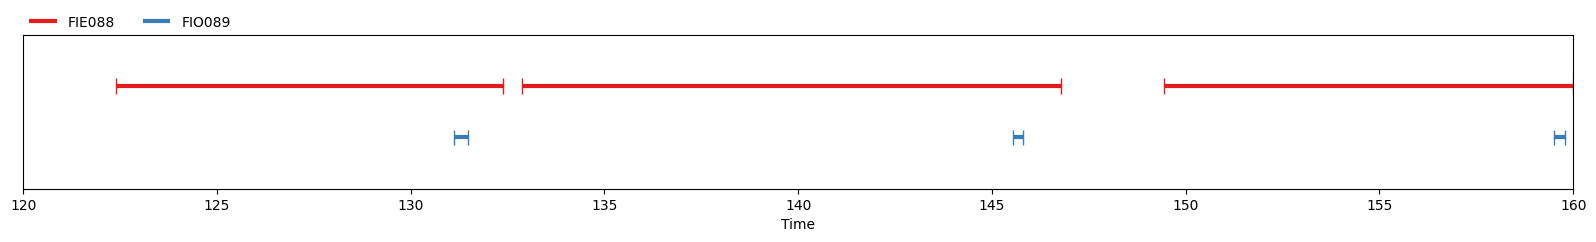

In [ ]:
file1["annotation"]

## Evaluating the Diarization Error Rate (DER)

In [ ]:
from pyannote.metrics.diarization import DiarizationErrorRate

def get_der(predictions, files):
  dermetric = DiarizationErrorRate()

  for file, pred in zip(files, predictions):
      # update der, computed between ground truth annotation and predicted
      # speech, on the file's uem.
      _ = dermetric(file["annotation"], pred, uem=file["annotated"])

  false_alarm = dermetric["false alarm"] / dermetric["total"]
  missed = dermetric["missed detection"] / dermetric["total"]
  confusion = dermetric["confusion"] / dermetric["total"]
  der = abs(dermetric)

  return false_alarm, missed, confusion, der


res_pt = {}
res_pt["fa"], res_pt["miss"], res_pt["conf"], res_pt["der"] = get_der([out_pretrained], [file1])

res_ad = {}
res_ad["fa"], res_ad["miss"], res_ad["conf"], res_ad["der"] = get_der([out_adapted], [file1])

print(f"On the first file of AMI mini ({file1['uri']}):")
print(f"{'Title':10} | {'FA%':>6} | {'MISS%':>6} | {'CONF%':>6} | {'DER%':>6}")
print(f"{'Pretrained':10} | {res_pt['fa']*100:6.2f} | {res_pt['miss']*100:6.2f} | {res_pt['conf']*100:6.2f} | {res_pt['der']*100:6.2f}")
print(f"{'Adapted':10} | {res_ad['fa']*100:6.2f} | {res_ad['miss']*100:6.2f} | {res_ad['conf']*100:6.2f} | {res_ad['der']*100:6.2f}")

On the first file of AMI mini (IS1009a):
Title      |    FA% |  MISS% |  CONF% |   DER%
Pretrained |   8.32 |   7.36 |  15.56 |  31.23
Adapted    |   7.72 |   6.66 |   6.75 |  21.12
